# ICON 2D map plotting

This script:
* reads vertex/cell data from ICON
* loads an ICON liquid water field
* integrates vertically
* makes 2D lat lon plots of the grid and LWP, using various tools in matplotlib's tri library

    Roel Neggers. IGMK, University of Cologne, 20201012


## Initialize



In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator

import netCDF4 as nc4

import math
import glob, os
from datetime import datetime

import seaborn as sns
sns.set()


case = "NARVAL"

   
filein = "ql_time47"


## Load ICON grid info

In [3]:
archive = "/data/testbed/ICON/experiments/NARVAL_RF08_20131220_Thirza/HDCP2_files/"
#archive = "/home/roel/ICON/runs/NARVAL_RF08_20131220_Thirza/HDCP2_files/"


gridfilename = "NarvalDom2_NestE-R02B14_DOM03.nc"

print("opening " + archive + gridfilename)
f = nc4.Dataset(archive + gridfilename,'r')


vlon           = np.array(f.variables["vlon"][:])               #(vertex)  double  vertex longitude radian

vlat           = np.array(f.variables["vlat"][:])               #(vertex)  double  vertex latitude  radian

vertex_of_cell = np.array(f.variables["vertex_of_cell"][:,:])   #(nv, cell)  int  vertices of each cell


nvert = vertex_of_cell.shape[0]
ncell = vertex_of_cell.shape[1]

print( (nvert,ncell))

f.close()

print("done")

print( (np.nanmin(np.rad2deg(vlon)),np.nanmax(np.rad2deg(vlon))))
print( (np.nanmin(np.rad2deg(vlat)),np.nanmax(np.rad2deg(vlat))))



opening /data/testbed/ICON/experiments/NARVAL_RF08_20131220_Thirza/HDCP2_files/NarvalDom2_NestE-R02B14_DOM03.nc
(3, 2846164)
done
(-59.752064145998226, -55.99796073454053)
(12.34862347433383, 13.851422837807402)


## Load ICON fields

In [7]:
filename = filein + ".nc"

print("opening " + archive + filename)
f = nc4.Dataset(archive + filename,'r')

qc_int = np.sum( np.array(f.variables["qc"][0,:,:]), axis=0 )   #int64 qc(time, height, ncells) 

f.close()

print("done")


opening /home/roel/ICON/runs/NARVAL_RF08_20131220_Thirza/HDCP2_files/ql_time47.nc
done


## Various 2D lat-lon plots

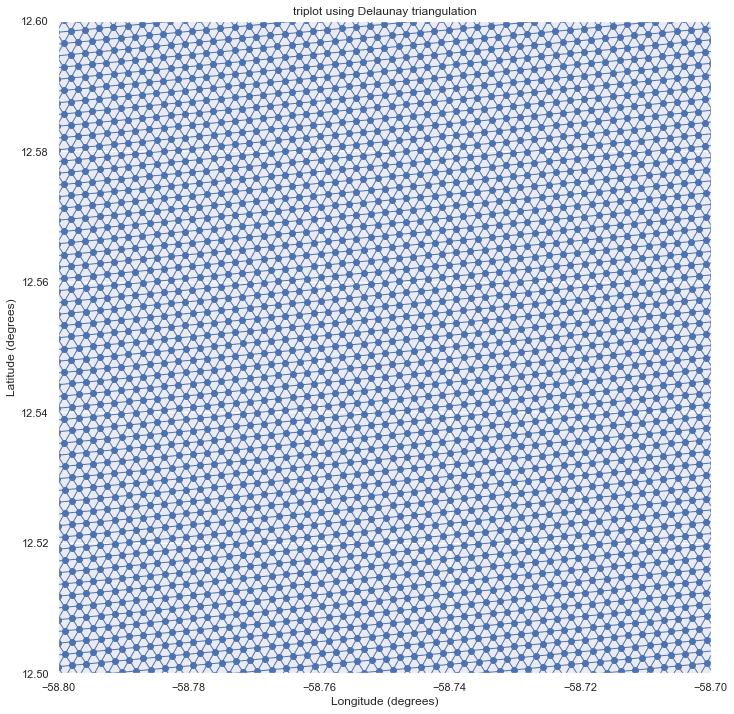

created output directory: plots_2Dmap/NARVAL


In [8]:
# Convert vertex coordinates from radians to degrees
x      = np.rad2deg(vlon)
y      = np.rad2deg(vlat)


# Create  Delaunay triangulation. 
triang = tri.Triangulation(x, y)
triang = tri.Triangulation(x, y)


# Use matplotlib's triplot to visualize the grid *without knowing which vertices belong to which cell*
fig, ax = plt.subplots(figsize=(24,12))

ax.set_aspect('equal')
ax.triplot(triang, 'bo-', lw=1)
ax.set_title('triplot using Delaunay triangulation')
ax.set_xlabel('Longitude (degrees)')
ax.set_ylabel('Latitude (degrees)')

ax.set_xlim([-58.8,-58.7])
ax.set_ylim([ 12.5, 12.6])

plt.show()

if not os.path.isdir('plots_2Dmap/'):
    os.mkdir('plots_2Dmap/')
    print("created output directory: " + 'plots_2Dmap/')
if not os.path.isdir('plots_2Dmap/' + case):
    os.mkdir('plots_2Dmap/' + case)
    print("created output directory: " + 'plots_2Dmap/' + case)

fig.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_triplot1_delaunay_' + filein + '.png', bbox_inches='tight')
#fig.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_triplot1_delaunay_' + filein + '.pdf', bbox_inches='tight')

plt.close(fig)


(3, 2846164)
(2846164, 3)


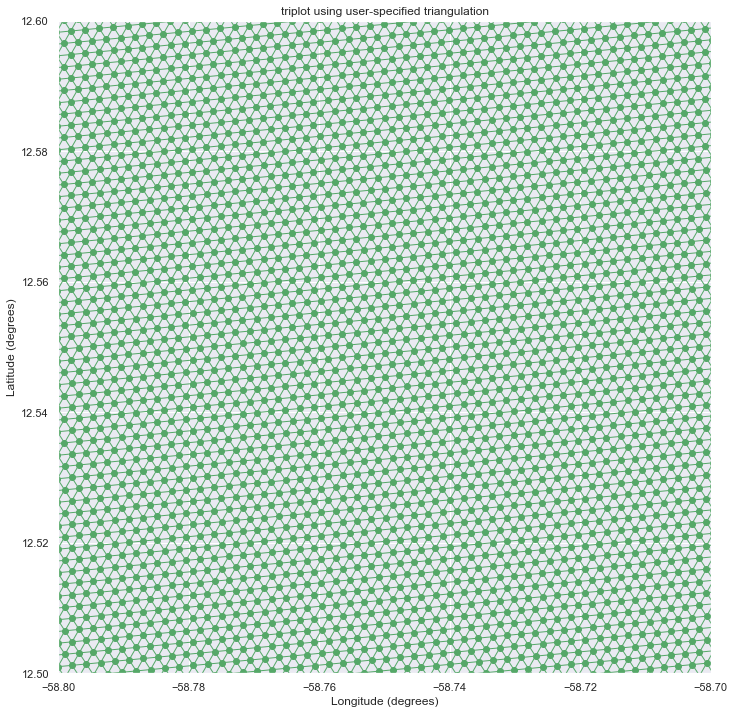

In [9]:
# dimensions of 3d argument to tripcolor should be (n_cell, 3), with 3 vertex-indices per triangular cell
# this is the variable "vertex_of_cell" in the ICON grid output
# note: array indexing starts at 1 in ICON output, should be 0 in NCL.
print(vertex_of_cell.shape)

triangles = np.transpose(vertex_of_cell) - 1   

print(triangles.shape)


# Use matplotlib's triplot to visualize the grid, 
#   now using knowledge of which vertices belong to which cell (vertex_of_cell)
#
fig2, ax2 = plt.subplots(figsize=(24,12))

ax2.set_aspect('equal')
ax2.triplot(x, y, triangles, 'go-', lw=1.0)
ax2.set_title('triplot using user-specified triangulation')
ax2.set_xlabel('Longitude (degrees)')
ax2.set_ylabel('Latitude (degrees)')

ax2.set_xlim([-58.8,-58.7])
ax2.set_ylim([ 12.5, 12.6])

plt.show()

fig2.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_triplot2_vertex-of-cell_' + filein + '.png', bbox_inches='tight')
#fig2.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_triplot2_vertex-of-cell_' + filein + '.pdf', bbox_inches='tight')

plt.close(fig2)




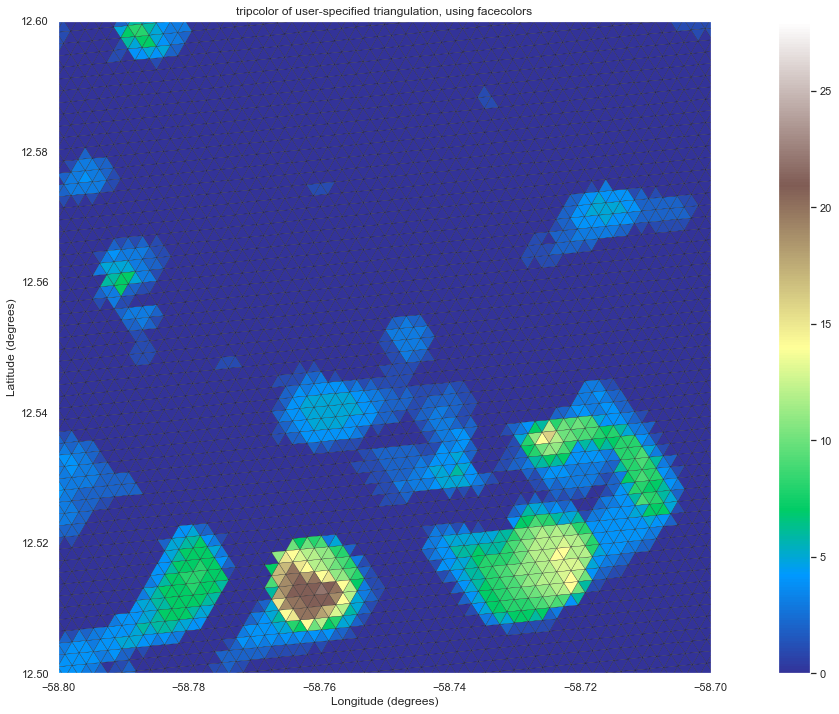

In [10]:

# matplotlib's tripcolor is a nice way to plot data on an unstructured triangular grid
# See https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tripcolor.html for more details
#
# the facecolors option is used to color each surface according to the ICON data (in this case cloud water)
#
# upside of using tripcolor: very fancy triangle plot!
# downside: takes a long time when using big grids, is much slower than tricontourf (see below)
#
fig3, ax3 = plt.subplots(figsize=(24,12))

ax3.set_aspect('equal')
tpc = ax3.tripcolor(x, y, triangles, facecolors=qc_int, cmap='terrain', edgecolors='k')
fig3.colorbar(tpc)
ax3.set_title('tripcolor of user-specified triangulation, using facecolors')
ax3.set_xlabel('Longitude (degrees)')
ax3.set_ylabel('Latitude (degrees)')

ax3.set_xlim([-58.8,-58.7])
ax3.set_ylim([ 12.5, 12.6])

plt.show()

fig3.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_tripcolor_' + filein + '.png', bbox_inches='tight')
#fig3.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_tripcolor_' + filein + '.pdf', bbox_inches='tight')

plt.close(fig3)



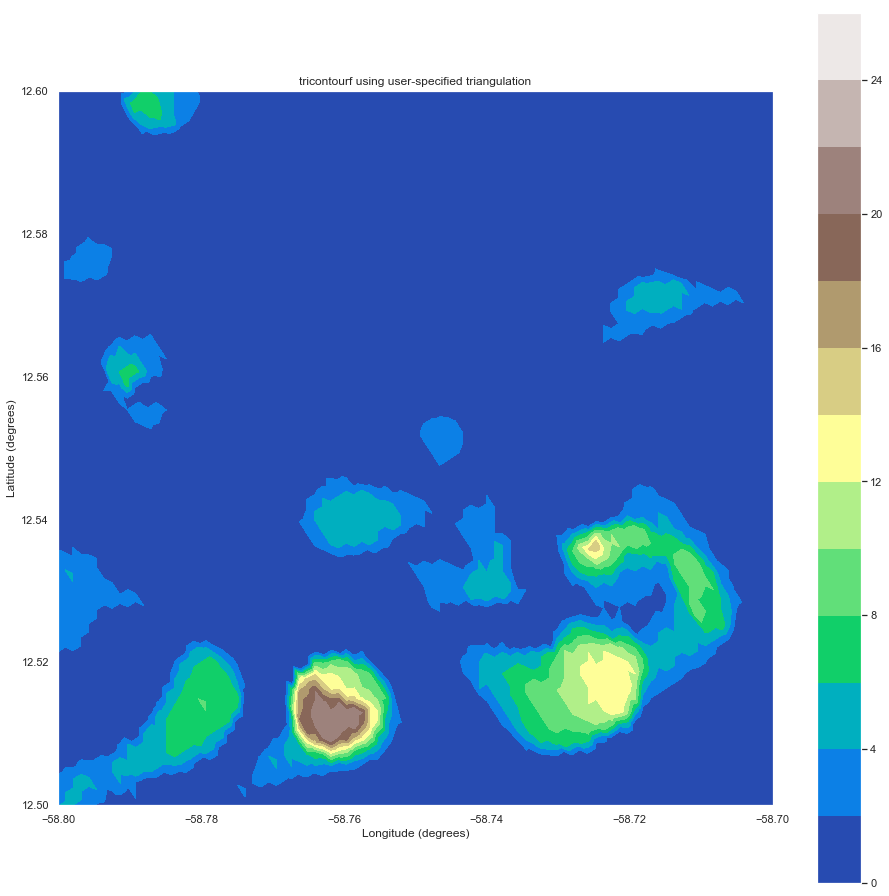

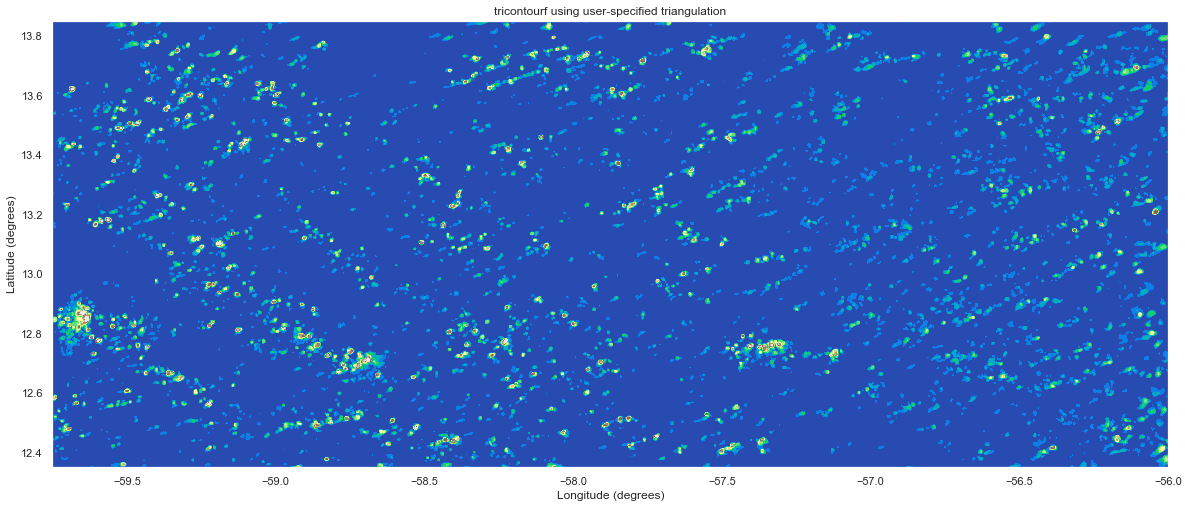

In [12]:
# Matplotlib's tricontourf also works, but 
#  the 3d argument (Z array) should have the same dimension as the x,y vertex arrays
# Reason: the contouring is done with the vertices as the gridpoints, not the cell centers.
# 
# See https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.tricontourf.html
#
xmid = x[triangles].mean(axis = 1) 
ymid = y[triangles].mean(axis = 1) 


# Plotting png images uses the agg backend, which suffers from the problem of a hardcoded limit 
# in the number of points in a line.
#   See
#     https://stackoverflow.com/questions/37470734/matplotlib-giving-error-overflowerror-in-draw-path-exceeded-cell-block-limit
#     https://github.com/matplotlib/matplotlib/issues/5907
#
# To solve this problem, increase the chunck size like this:
#
mpl.rcParams['agg.path.chunksize'] = 10000



# Then use tricontourf
#
levels = np.arange(0., 28, 2.)

cmap = cm.get_cmap(name='terrain', lut=None)

fig4, ax4 = plt.subplots(figsize=(16,16))

ax4.set_aspect('equal')
#tpc = ax4.tricontourf(xmid, ymid, triangles, qc_int, levels=levels, cmap=cmap)
tpc = ax4.tricontourf(xmid, ymid, qc_int, levels=levels, cmap=cmap)
fig4.colorbar(tpc)
ax4.set_title('tricontourf using user-specified triangulation')
ax4.set_xlabel('Longitude (degrees)')
ax4.set_ylabel('Latitude (degrees)')

ax4.set_xlim([-58.8,-58.7])
ax4.set_ylim([ 12.5, 12.6])

plt.show()

fig4.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_tricontourf_' + filein + '.png', bbox_inches='tight')
#fig4.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_tricontourf_' + filein + '.pdf', bbox_inches='tight')

plt.close(fig4)


ig4, ax4 = plt.subplots(figsize=(20,10))

ax4.set_aspect('equal')
tpc = ax4.tricontourf(xmid, ymid, qc_int, levels=levels, cmap=cmap)
fig4.colorbar(tpc)
ax4.set_title('tricontourf using user-specified triangulation')
ax4.set_xlabel('Longitude (degrees)')
ax4.set_ylabel('Latitude (degrees)')

plt.show()

fig4.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_tricontourf_' + filein + '_full.png', bbox_inches='tight')
#fig4.savefig('plots_2Dmap/' + case + '/ICON_2Dmap_tricontourf_' + filein + '_full.pdf', bbox_inches='tight')

plt.close(fig4)
